In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Activation,Conv2D,MaxPooling2D,Flatten,Dropout,BatchNormalization
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from keras.applications import EfficientNetB0,EfficientNetV2B0
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import os
import cv2



In [3]:
labels=['NORMAL','PNEUMONIA']
img_size=224
def get_data(data_dir):
    data=[]
    for label in labels:
        path=os.path.join(data_dir,label)
        class_num=labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr=cv2.imread(os.path.join(path,img))
                resized_arr=cv2.resize(img_arr,(img_size,img_size))
                data.append([resized_arr,class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [4]:
df_train=get_data("/content/drive/MyDrive/chest_xray/train")

In [5]:
df_test=get_data("/content/drive/MyDrive/chest_xray/test")

In [6]:
df_val=get_data("/content/drive/MyDrive/chest_xray/val")

In [7]:
h=0;
p=0;
for i in range(len(df_train)):
    if df_train[i][1]==0:
        h+=1
    else:
        p+=1

print("NORMAL: ",h)
print("PNEUMONIA: ",p)


NORMAL:  1341
PNEUMONIA:  3875


In [8]:

h=0;
p=0;
for i in range(len(df_test)):
    if df_test[i][1]==0:
        h+=1
    else:
        p+=1

print("NORMAL: ",h)
print("PNEUMONIA: ",p)

NORMAL:  234
PNEUMONIA:  390


In [9]:
h=0;
p=0;
for i in range(len(df_val)):
    if df_val[i][1]==0:
        h+=1
    else:
        p+=1

print("NORMAL: ",h)
print("PNEUMONIA: ",p)

NORMAL:  8
PNEUMONIA:  8


In [10]:
x_train=[]
y_train=[]

x_test=[]
y_test=[]

x_val=[]
y_val=[]


for feature, label in df_train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in df_test:
    x_test.append(feature)
    y_test.append(label)

for feature, label in df_val:
    x_val.append(feature)
    y_val.append(label)

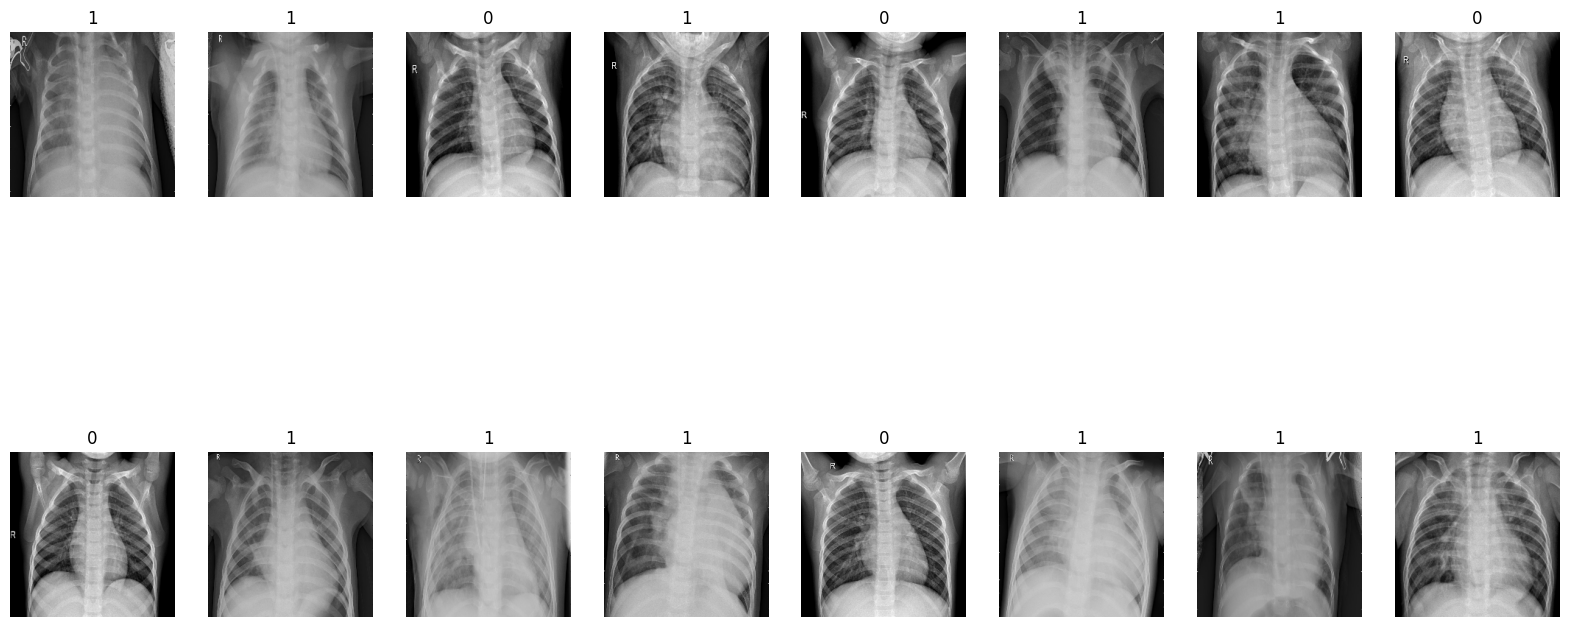

In [11]:
plt.figure(figsize=(20,10))
for n , i in enumerate(np.random.randint(0,len(x_train),16)): 
    plt.subplot(2,8,n+1)
    plt.imshow(x_train[i])
    plt.axis('off')
    plt.title(y_train[i])

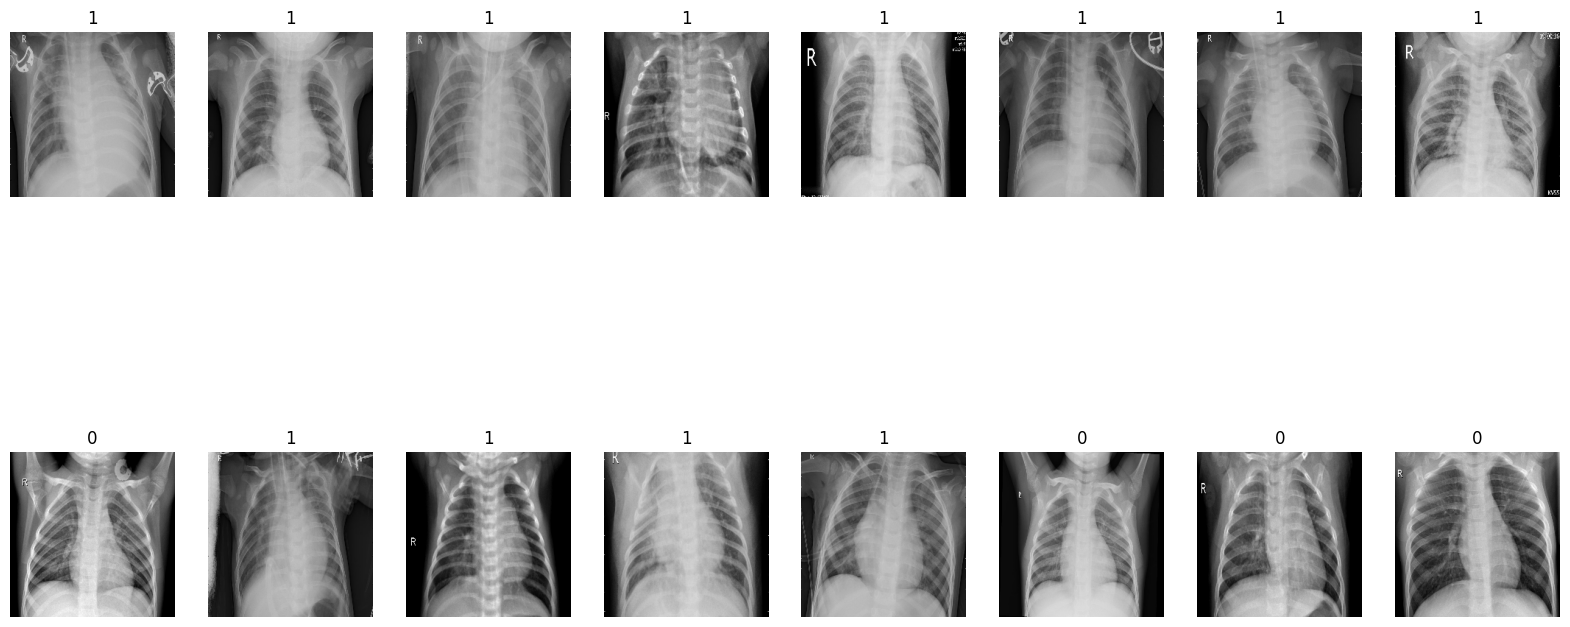

In [12]:
plt.figure(figsize=(20,10))
for n , i in enumerate(np.random.randint(0,len(x_test),16)): 
    plt.subplot(2,8,n+1)
    plt.imshow(x_test[i])
    plt.axis('off')
    plt.title(y_test[i])

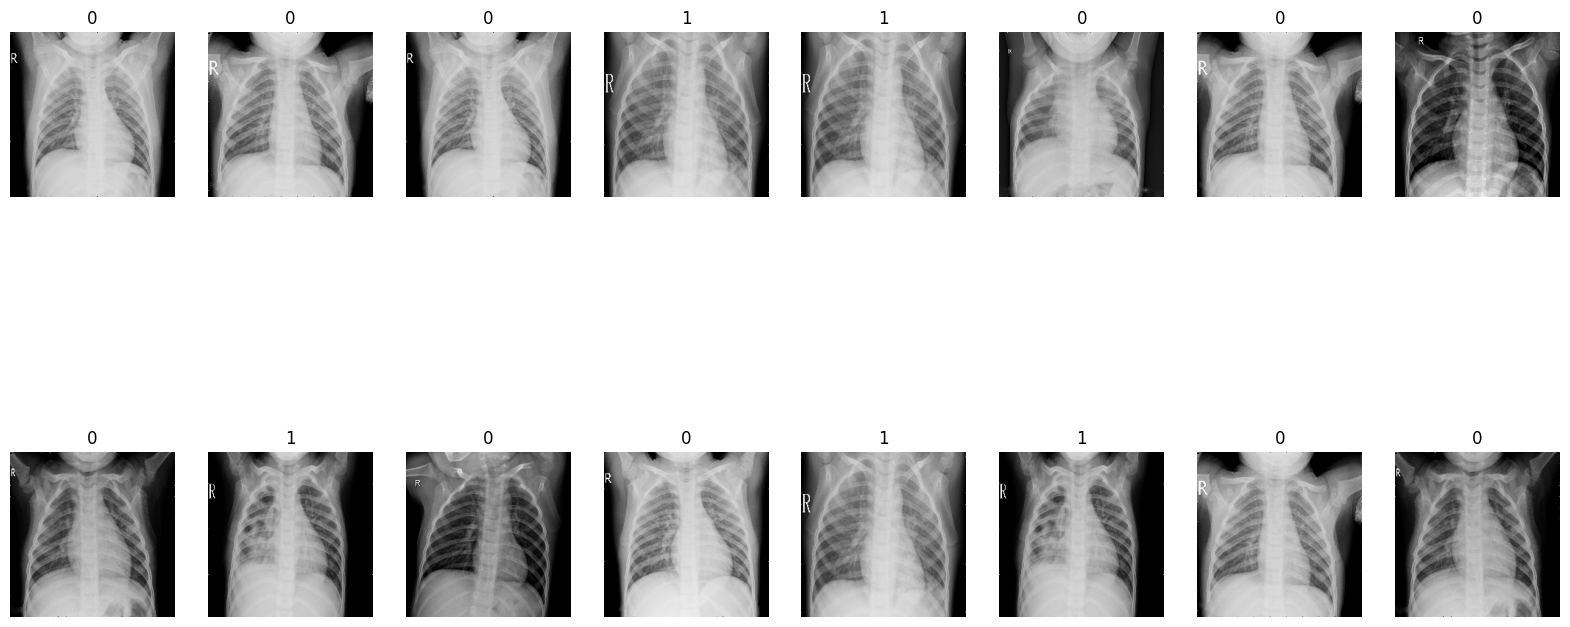

In [13]:
plt.figure(figsize=(20,10))
for n , i in enumerate(np.random.randint(0,len(x_val),16)): 
    plt.subplot(2,8,n+1)
    plt.imshow(x_val[i])
    plt.axis('off')
    plt.title(y_val[i])

In [14]:
def plotHistogram(a):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(a)
    histo = plt.subplot(1,2,2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    n_bins = 30
    plt.hist(a[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5)
    plt.hist(a[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5)
    plt.hist(a[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5)


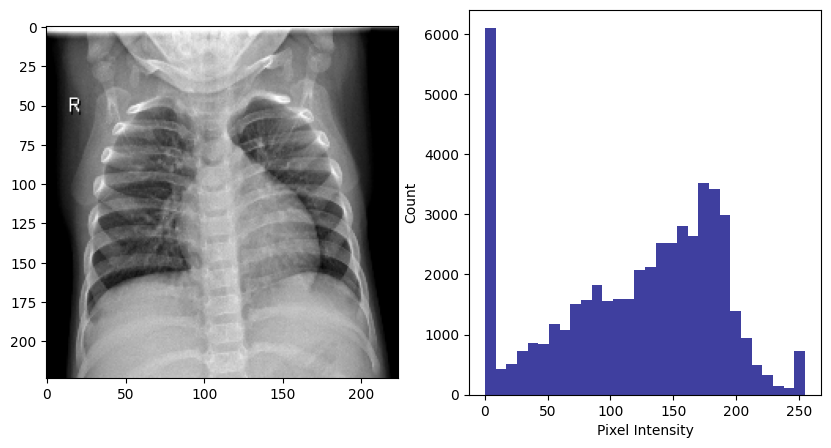

In [15]:
plotHistogram(x_train[np.random.randint(len(x_train))])

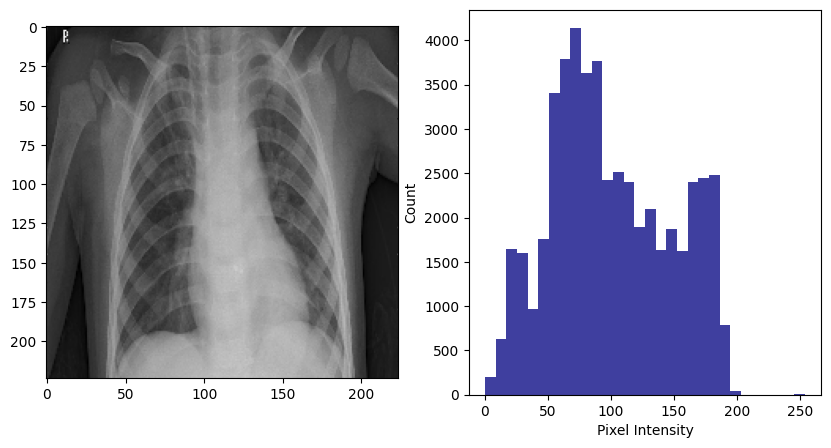

In [16]:
plotHistogram(x_test[np.random.randint(len(x_test))])

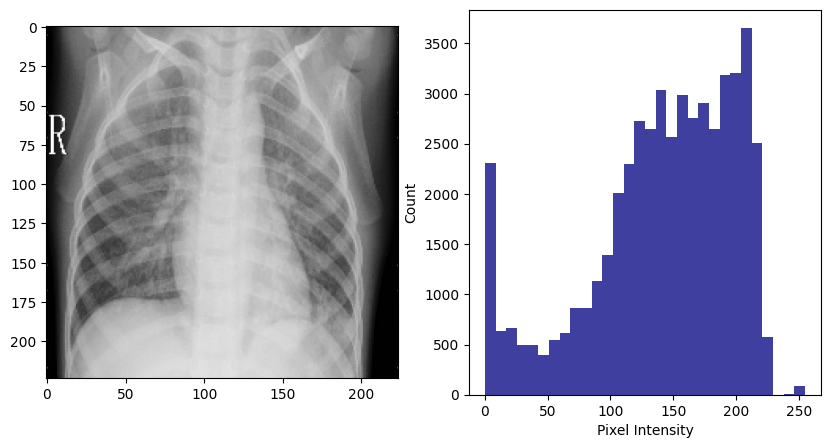

In [17]:
plotHistogram(x_val[np.random.randint(len(x_val))])

In [18]:
x_train=np.array(x_train)
y_train=np.array(y_train).reshape(-1,1)
x_test=np.array(x_test)
y_test=np.array(y_test).reshape(-1,1)
x_val=np.array(x_val)
y_val=np.array(y_val)


In [19]:
y_train=tf.keras.utils.to_categorical(
    y_train, num_classes=2)


In [20]:
y_test=tf.keras.utils.to_categorical(
    y_test, num_classes=2)

In [21]:
y_test.shape

(624, 2)

In [22]:
x_train.shape

(5216, 224, 224, 3)

In [23]:
x_val.shape

(16, 224, 224, 3)

In [24]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = 2
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'sigmoid')
])

model.compile(Adam(learning_rate= 0.001), loss= 'binary_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 4,383,141
Trainable params: 4,338,558
Non-trainable params: 44,583
_________________________________________

In [25]:
history = model.fit(x_train, y_train,batch_size=10,
                    epochs=5,
                    verbose=1,
                   validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)

Epoch 1/5
522/522 [==============================] - 1594s 3s/step - loss: 1.4649 - accuracy: 0.9360 - val_loss: 0.7535 - val_accuracy: 0.8093
Epoch 2/5
522/522 [==============================] - 1587s 3s/step - loss: 0.3778 - accuracy: 0.9442 - val_loss: 0.7941 - val_accuracy: 0.8317
Epoch 3/5
522/522 [==============================] - 1568s 3s/step - loss: 0.3780 - accuracy: 0.9369 - val_loss: 0.9344 - val_accuracy: 0.7901
Epoch 4/5
522/522 [==============================] - 1554s 3s/step - loss: 0.3015 - accuracy: 0.9567 - val_loss: 0.6648 - val_accuracy: 0.7965
Epoch 5/5
522/522 [==============================] - 1597s 3s/step - loss: 0.2766 - accuracy: 0.9603 - val_loss: 1.0106 - val_accuracy: 0.7388


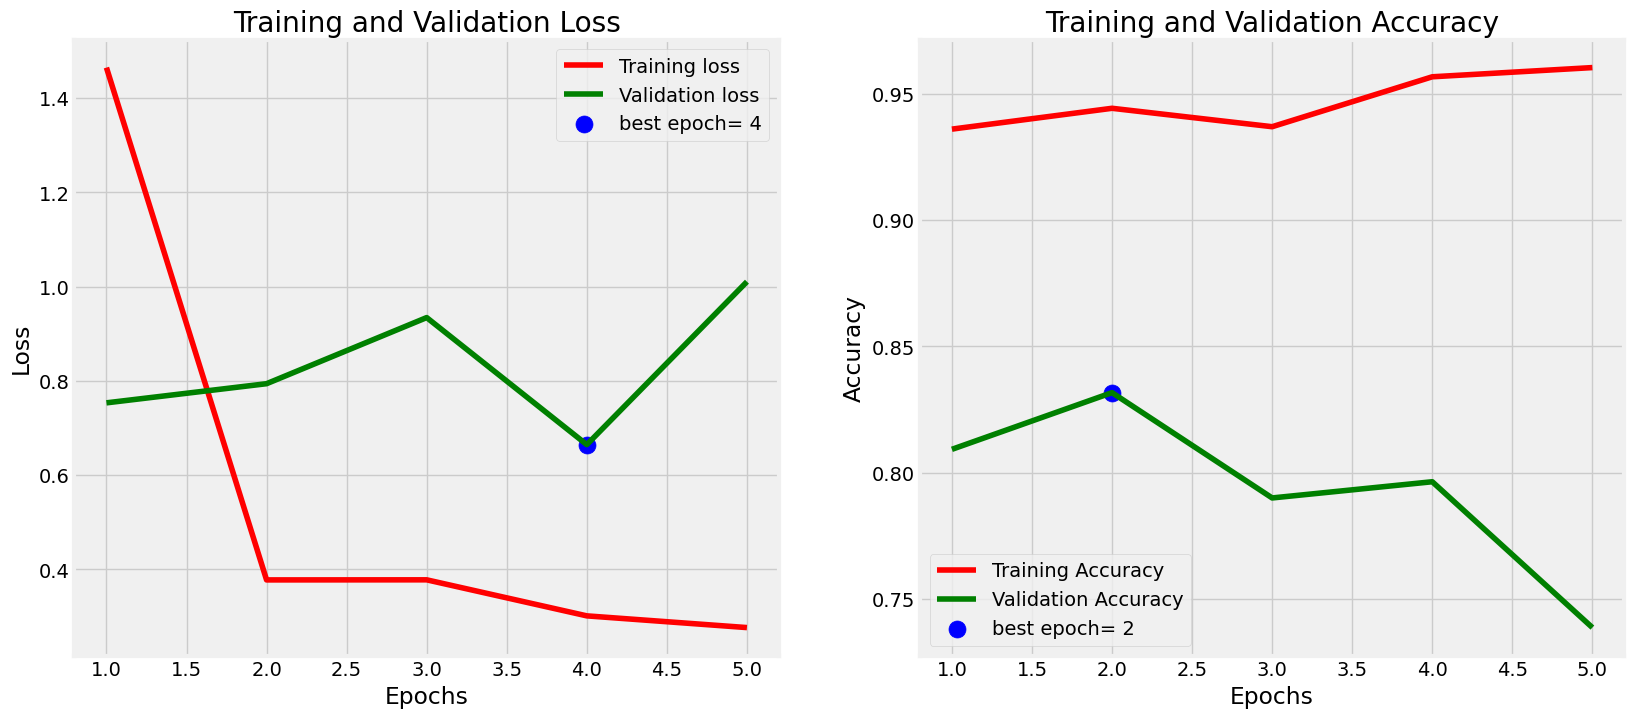

In [26]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [29]:
import pickle

In [30]:
pickle.dump(model, open('model.pkl', 'wb'))